In [4]:
# Imports

import re
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from tqdm import tqdm

In [5]:
# Paths

data_path = "../data/raw-refs-abs"
table_path = "../reports/tables"
figure_path = "../reports/figures"

In [15]:
# Constants

CREATE_ABSTRACTS_DATASET = False

# Number of topics used for K-means
n_topics = 8

#### Create Abstracts dataset (only need to do this once)

In [9]:
DATA_PATH = Path(data_path)  # folder with subfolders per query
records = []

if CREATE_ABSTRACTS_DATASET:

    for folder in sorted(DATA_PATH.iterdir()):
        if not folder.is_dir():
            continue
        query_id = folder.name
        jsonl_files = list(folder.glob("*.jsonl"))
        for fp in jsonl_files:
            with fp.open("r", encoding="utf-8") as f:
                for line in f:
                    line = line.strip()
                    if not line:
                        continue
                    try:
                        rec = json.loads(line)
                    except json.JSONDecodeError:
                        continue

                    abs_txt = rec.get("abstract") or rec.get("description") or ""
                    if isinstance(abs_txt, list):
                        abs_txt = " ".join(str(x) for x in abs_txt if x)

                    records.append({
                        "query_id": query_id,
                        "eid": rec.get("eid"),
                        "doi": rec.get("doi"),
                        "title": rec.get("title"),
                        "coverDate": rec.get("coverDate"),
                        "abstract": abs_txt.strip()
                    })

    df_abs = pd.DataFrame(records)
    print(f"Collected {len(df_abs)} abstracts from {len(df_abs['query_id'].unique())} queries")

    # Save for later analysis
    out_path = Path("../data/processed/abstracts.csv")
    df_abs.to_csv(out_path, index=False)
    print(f"Saved → {out_path}")


In [ ]:
# Load Data

# Load dataframe with abstracts ( only rows that includes an abstract )
df = pd.read_csv("../data/processed/abstracts.csv") 
df = df.dropna(subset=["abstract"]).reset_index(drop=True)
print(f"Loaded {len(df)} abstracts")


Loaded 3250 abstracts


In [12]:
# Clean Abstracts

# Basic text cleaning
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

df["clean_abs"] = df["abstract"].apply(clean_text)
df.head(2)


,query_id,eid,doi,title,coverDate,abstract,clean_abs
0,ml_manufacturing_optimization,2-s2.0-105014515088,10.1016/j.eswa.2025.129467,Reinforcement learning enhanced imperialist co...,2026-02-01,© 2025In the complex landscape of multi-dimens...,in the complex landscape of multidimensional c...
1,ml_manufacturing_optimization,2-s2.0-105012952464,10.1016/j.future.2025.108042,Resource-adaptive successive doubling for hype...,2026-02-01,© 2025 The AuthorsThe accuracy of Machine Lear...,the authorsthe accuracy of machine learning ml...


In [13]:
# TF-IDF vectorization

# Convert cleaned abstracts to TF-IDF features
tfidf = TfidfVectorizer(max_features=5000, stop_words="english")
X = tfidf.fit_transform(df["clean_abs"])

print(f"TF-IDF shape: {X.shape}")


TF-IDF shape: (3250, 5000)


In [16]:
# K-Means topic clustering

km = KMeans(n_clusters=n_topics, random_state=42)
df["topic"] = km.fit_predict(X)

df["topic"].value_counts().sort_index()

topic
0     199
1     296
2    1165
3     418
4     186
5     333
6     191
7     462
Name: count, dtype: int64

In [17]:
# Show top TF-IDF words per topic
terms = tfidf.get_feature_names_out()

for i in range(n_topics):
    idx = km.cluster_centers_[i].argsort()[::-1][:10]
    top_terms = [terms[j] for j in idx]
    print(f"Topic {i}: {', '.join(top_terms)}")


Topic 0: land, water, agricultural, soil, spatial, climate, change, areas, model, urban
Topic 1: energy, solar, power, wind, forecasting, renewable, electricity, consumption, models, model
Topic 2: product, data, model, development, learning, models, machine, process, design, analysis
Topic 3: manufacturing, digital, systems, data, twin, process, maintenance, production, industry, technologies
Topic 4: crop, yield, agricultural, food, agriculture, soil, farmers, data, prediction, models
Topic 5: ai, design, product, development, intelligence, artificial, process, drug, ml, technologies
Topic 6: reservoir, oil, wells, field, drilling, production, model, gas, data, development
Topic 7: production, planning, scheduling, problem, supply, learning, time, manufacturing, demand, optimization


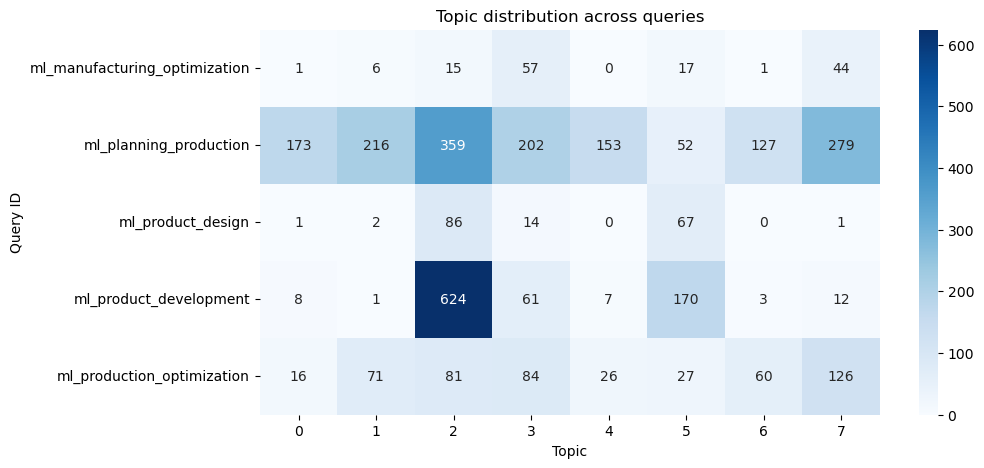

In [18]:
# Count how many abstracts per query belong to each topic
topic_dist = df.groupby(["query_id", "topic"]).size().unstack(fill_value=0)

plt.figure(figsize=(10,5))
sns.heatmap(topic_dist, cmap="Blues", annot=True, fmt="d")
plt.title("Topic distribution across queries")
plt.ylabel("Query ID")
plt.xlabel("Topic")
plt.show()


In [19]:
# Save results for later analysis
df.to_csv("../reports/tables/abstract_topics.csv", index=False)
print("Saved topic assignments to ../reports/tables/abstract_topics.csv")


Saved topic assignments to ../reports/tables/abstract_topics.csv
